# Surface wave and receiver function - joint inversion

In [1]:
import bayesbay as bb
from bayesbay.discretization import Voronoi1D

from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from disba import PhaseDispersion
import espresso

In [2]:
np.random.seed(30)
np.seterr(all="ignore");

In [3]:
THICKNESS = np.array([10, 10, 15, 20, 20, 20, 20, 20, 0])
VS = np.array([3.38, 3.44, 3.66, 4.25, 4.35, 4.32, 4.315, 4.38, 4.5])
VP_VS = 1.77
VP = VS * VP_VS
RHO = 0.32 * VP + 0.77

In [4]:
def initialize_vs(param, positions=None):
    vmin, vmax = param.get_vmin_vmax(positions)
    sorted_vals = np.sort(np.random.uniform(vmin, vmax, positions.size))
    return sorted_vals

vs = bb.prior.UniformPrior(name="vs", 
                           vmin=[2.2, 2.8, 3.3, 4], 
                           vmax=[3.9, 4.6, 4.8, 5], 
                           position=[0, 20, 60, 150],
                           perturb_std=0.15)
vs.set_custom_initialize(initialize_vs)

voronoi = Voronoi1D(
    name="voronoi", 
    vmin=0,
    vmax=150,
    perturb_std=10,
    n_dimensions=None, 
    n_dimensions_min=4,
    n_dimensions_max=15,
    parameters=[vs], 
    birth_from='neighbour'
)
parameterization = bb.parameterization.Parameterization(voronoi)

### Surface wave

In [5]:
PERIODS = np.geomspace(3, 80, 20)
RAYLEIGH_STD = 0.02
LOVE_STD = 0.02

In [6]:
def forward_sw(state, wave='rayleigh', mode=0):
    voronoi = state["voronoi"]
    voronoi_sites = voronoi["discretization"]
    thickness = Voronoi1D.compute_cell_extents(voronoi_sites)
    vs = voronoi["vs"]
    vp = vs * VP_VS
    rho = 0.32 * vp + 0.77
    pd = PhaseDispersion(thickness, vp, vs, rho)
    d_pred = pd(PERIODS, mode=mode, wave=wave).velocity
    return d_pred

forward_rayleigh = partial(forward_sw, wave='rayleigh', mode=0)
forward_love = partial(forward_sw, wave='love', mode=0)

In [7]:
pd = PhaseDispersion(THICKNESS, VP, VS, RHO)
rayleigh = pd(PERIODS, mode=0, wave="rayleigh").velocity
love = pd(PERIODS, mode=0, wave="love").velocity
rayleigh_obs = rayleigh + np.random.normal(0, RAYLEIGH_STD, rayleigh.size)
love_obs = love + np.random.normal(0, LOVE_STD, love.size)

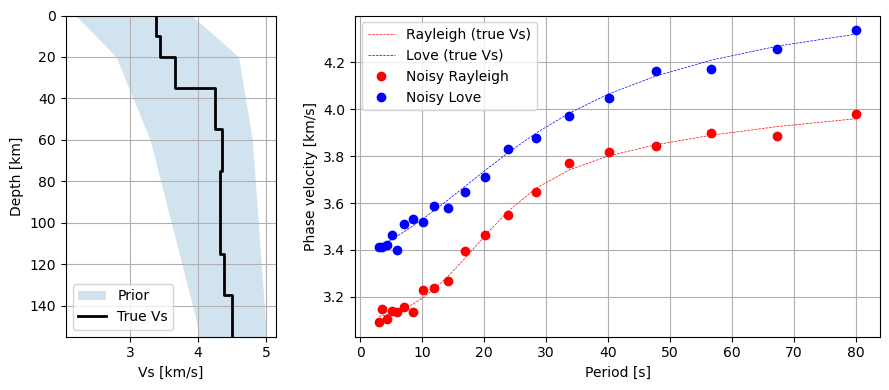

In [8]:
depth_prior = np.linspace(0, 200)
vmin_prior, vmax_prior = vs.get_vmin_vmax(depth_prior)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={'width_ratios': [1, 2.5]})
ax1.fill_betweenx(depth_prior, vmin_prior, vmax_prior, alpha=0.2, label='Prior')
Voronoi1D.plot_tessellation(THICKNESS, 
                            VS, 
                            label='True Vs', 
                            ax=ax1, 
                            color='k', 
                            lw=2, 
                            input_type='extents')
ax1.set_xlabel('Vs [km/s]')
ax1.set_ylabel('Depth [km]')
ax1.set_ylim(np.cumsum(THICKNESS)[-1] + max(THICKNESS), 0)
ax1.grid()
ax1.legend()

ax2.plot(PERIODS, rayleigh, 'r--', label='Rayleigh (true Vs)', lw=0.5)
ax2.plot(PERIODS, love, 'b--', label='Love (true Vs)', lw=0.5)
ax2.plot(PERIODS, rayleigh_obs, 'ro', label='Noisy Rayleigh')
ax2.plot(PERIODS, love_obs, 'bo', label='Noisy Love')
ax2.set_xlabel('Period [s]')
ax2.set_ylabel('Phase velocity [km/s]')
ax2.grid()
ax2.legend()

plt.tight_layout(w_pad=2)
plt.show()

### Receiver function

In [9]:
RF_LIB = espresso.ReceiverFunctionInversionKnt().rf
T_SHIFT = 5
T_DURATION = 25
T_SAMPLING_INTERVAL = 0.1
GAUSS = 1
RAY_PARAM_S_KM = 0.07
RF_STD = 0.015

In [10]:
def forward_rf(state):
    voronoi = state["voronoi"]
    voronoi_sites = voronoi["discretization"]
    thickness = Voronoi1D.compute_cell_extents(voronoi_sites)
    vs = voronoi["vs"]
    return RF_LIB.rf_calc(
        ps=0, 
        thik=thickness, 
        beta=vs, 
        kapa=np.ones((len(vs),))*VP_VS,
        p=RAY_PARAM_S_KM, 
        duration=T_DURATION, 
        dt=T_SAMPLING_INTERVAL, 
        shft=T_SHIFT, 
        gauss=GAUSS
    )

In [11]:
rf = RF_LIB.rf_calc(
    ps=0, 
    thik=THICKNESS, 
    beta=VS, 
    kapa=np.ones((len(VS),))*VP_VS,
    p=RAY_PARAM_S_KM, 
    duration=T_DURATION, 
    dt=T_SAMPLING_INTERVAL, 
    shft=T_SHIFT, 
    gauss=GAUSS
)
rf_obs = rf + np.random.normal(0, RF_STD, rf.size)

RF_TIMES = np.arange(len(rf_obs)) * T_SAMPLING_INTERVAL - T_SHIFT

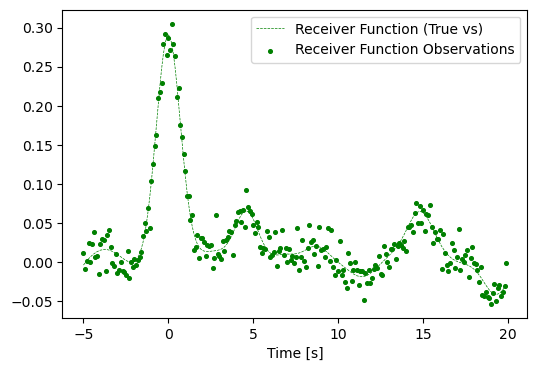

In [28]:
_, ax = plt.subplots(figsize=(6, 4))

ax.plot(RF_TIMES, rf, 'g--', label="Receiver Function (True vs)", lw=0.5)
ax.scatter(RF_TIMES, rf_obs, label="Receiver Function Observations", s=7, c="g")
ax.set_xlabel("Time [s]")
ax.legend()

## Sample with BayesBay

In [13]:
target_rayleigh = bb.Target("rayleigh", 
                            rayleigh_obs, 
                            std_min=0.001, 
                            std_max=0.1, 
                            std_perturb_std=0.002)
target_love = bb.Target("love", 
                        love_obs, 
                        std_min=0.001, 
                        std_max=0.1, 
                        std_perturb_std=0.002)
target_rf = bb.Target("rf", 
                      rf_obs, 
                      std_min=0.001, 
                      std_max=0.1, 
                      std_perturb_std=0.002)

targets = [target_rayleigh, target_love, target_rf]
fwd_functions = [forward_rayleigh, forward_love, forward_rf]

log_likelihood = bb.LogLikelihood(targets, fwd_functions)

In [14]:
inversion = bb.BayesianInversion(
    parameterization=parameterization, 
    log_likelihood=log_likelihood,
    n_chains=24
)
inversion.run(
    sampler=bb.samplers.SimulatedAnnealing(temperature_start=3), 
    n_iterations=600_000, 
    burnin_iterations=150_000, 
    save_every=150,
    verbose=False
)

## Plot results

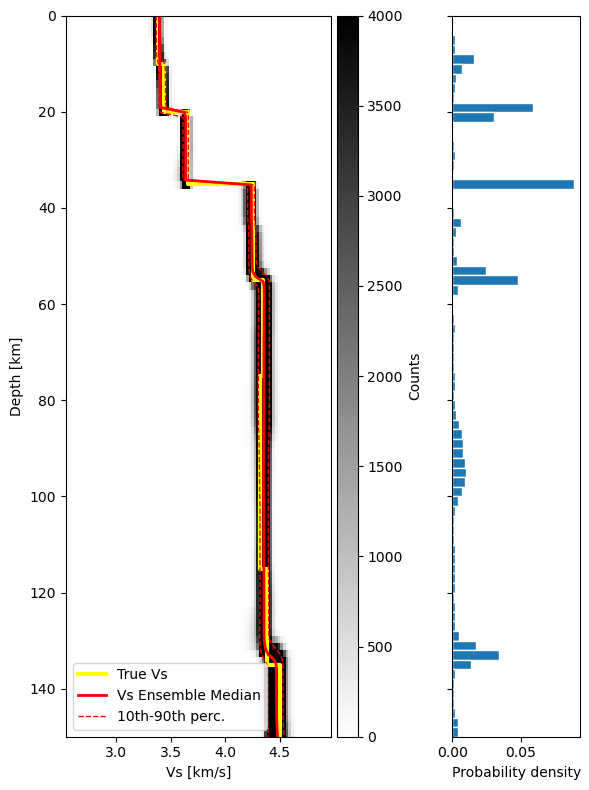

In [47]:
results = inversion.get_results(concatenate_chains=True)

sampled_voronoi_nuclei = results['voronoi.discretization']
sampled_thickness = [Voronoi1D.compute_cell_extents(n) for n in sampled_voronoi_nuclei]
sampled_vs = results['voronoi.vs']
interp_depths = np.linspace(0, 160, 160)
statistics_vs = Voronoi1D.get_tessellation_statistics(
    sampled_thickness, sampled_vs, interp_depths, input_type='extents'
    )

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 8), gridspec_kw={'width_ratios': [2.5, 1]})
ax1, cbar = Voronoi1D.plot_tessellation_density(sampled_thickness, 
                                                sampled_vs, 
                                                input_type='extents', 
                                                ax=ax1, 
                                                cmap='binary', 
                                                vmin=0, 
                                                vmax=4000)
Voronoi1D.plot_tessellation(THICKNESS, 
                            VS, 
                            ax=ax1, 
                            color='yellow', 
                            lw=3, 
                            label='True Vs',
                            input_type='extents')
#ax1.plot(statistics_vs['mean'], interp_depths, 'b', lw=2, label='Vs Ensemble Mean')
ax1.plot(statistics_vs['median'], interp_depths, 'r', lw=2, label='Vs Ensemble Median')
ax1.plot(statistics_vs['percentiles'][0], interp_depths, 'r--', lw=1, label='10th-90th perc.')
ax1.plot(statistics_vs['percentiles'][1], interp_depths, 'r--', lw=1)
                  
ax1.set_xlabel("Vs [km/s]")
ax1.set_ylabel("Depth [km]")
ax1.legend()

Voronoi1D.plot_interface_hist(sampled_thickness, input_type='extents', bins=75, ec='w', ax=ax2)
ax2.tick_params(labelleft=False)
ax2.set_ylabel('')
ax2.set_ylim(*ax1.get_ylim())
plt.tight_layout()
plt.show()

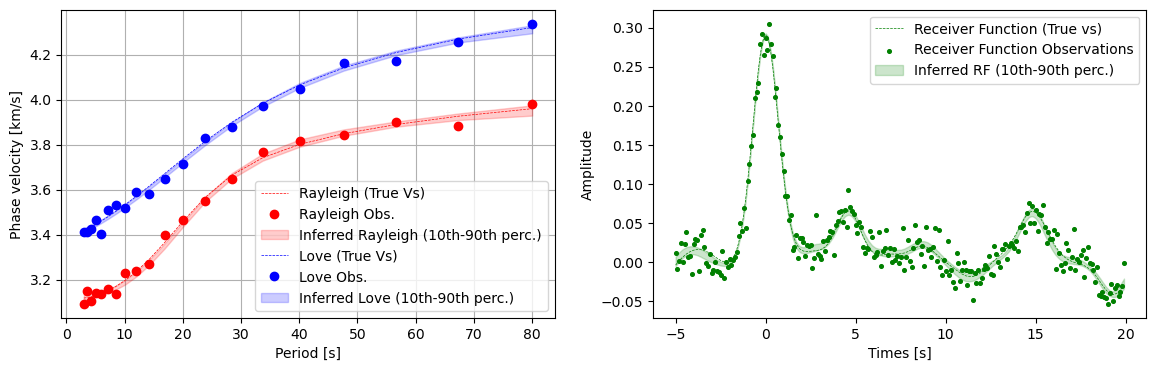

In [33]:
rayleigh_pred = np.array(results['rayleigh.dpred'])
love_pred = np.array(results['love.dpred'])
rf_pred = np.array(results['rf.dpred'])
rayleigh_percentiles = np.percentile(rayleigh_pred, (10, 90), axis=0)
love_percentiles = np.percentile(love_pred, (10, 90), axis=0)
rf_percentiles = np.percentile(rf_pred, (10, 90), axis=0)

# Predicted dispersion curves

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
ax1.plot(PERIODS, rayleigh, 'r--', label='Rayleigh (True Vs)', lw=0.5)
ax1.plot(PERIODS, rayleigh_obs, 'ro', label='Rayleigh Obs.')
ax1.fill_between(PERIODS, 
                 rayleigh_percentiles[0], 
                 rayleigh_percentiles[1], 
                 color='r', 
                 alpha=0.2, 
                 label='Inferred Rayleigh (10th-90th perc.)', 
                 zorder=100)
ax1.plot(PERIODS, love, 'b--', label='Love (True Vs)', lw=0.5)
ax1.plot(PERIODS, love_obs, 'bo', label='Love Obs.')
ax1.fill_between(PERIODS, 
                 love_percentiles[0], 
                 love_percentiles[1], 
                 color='b', 
                 alpha=0.2, 
                 label='Inferred Love (10th-90th perc.)', 
                 zorder=100)
ax1.set_xlabel('Period [s]')
ax1.set_ylabel('Phase velocity [km/s]')
ax1.grid()
ax1.legend()


ax2.plot(RF_TIMES, rf, 'g--', label="Receiver Function (True vs)", lw=0.5)
ax2.scatter(RF_TIMES, rf_obs, label="Receiver Function Observations", s=7, c="g")
ax2.fill_between(RF_TIMES, 
                 rf_percentiles[0], 
                 rf_percentiles[1], 
                 color='g', 
                 alpha=0.2, 
                 label='Inferred RF (10th-90th perc.)', 
                 zorder=100)
ax2.set_xlabel("Times [s]")
ax2.set_ylabel("Amplitude")
ax2.legend()

plt.show()

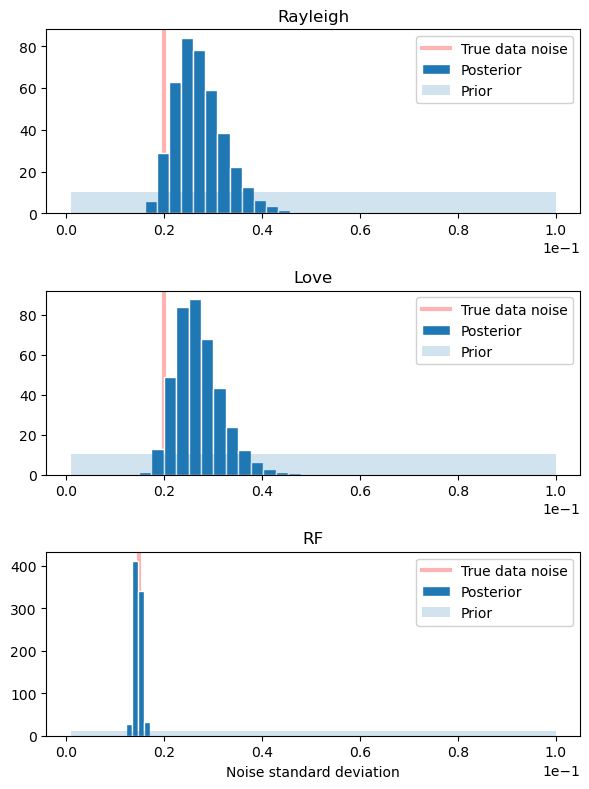

In [39]:
# Histograms of inferred data noise
std_min_sw, std_max_sw = target_love.std_min, target_love.std_max
std_min_rf, std_max_rf = target_rf.std_min, target_rf.std_max

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8))
ax1.axvline(x=RAYLEIGH_STD, color='r', lw=3, alpha=0.3, label='True data noise', zorder=0)
pdf, bins, _ = ax1.hist(results['rayleigh.std'], density=True, bins=20, ec='w', label='Posterior')
ax1.fill_between([std_min_sw, std_max_sw], 1 / (std_max_sw - std_min_sw), alpha=0.2, label='Prior')
ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax1.legend(framealpha=0.9, loc='upper right')
ax1.set_title('Rayleigh')

ax2.axvline(x=LOVE_STD, color='r', lw=3, alpha=0.3, label='True data noise', zorder=0)
pdf, bins, _ = ax2.hist(results['love.std'], density=True, bins=20, ec='w',  label='Posterior')
ax2.fill_between([std_min_sw, std_max_sw], 1 / (std_max_sw - std_min_sw), alpha=0.2, label='Prior')
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax2.legend(framealpha=0.9, loc='upper right')
ax2.set_title('Love')

ax3.axvline(x=RF_STD, color='r', lw=3, alpha=0.3, label='True data noise', zorder=0)
pdf, bins, _ = ax3.hist(results['rf.std'], density=True, bins=5, ec='w',  label='Posterior')
ax3.fill_between([std_min_rf, std_max_rf], 1 / (std_max_rf - std_min_rf), alpha=0.2, label='Prior')
ax3.set_xlabel('Noise standard deviation')
ax3.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax3.legend(framealpha=0.9, loc='upper right')
ax3.set_title('RF')

plt.tight_layout()
plt.show()

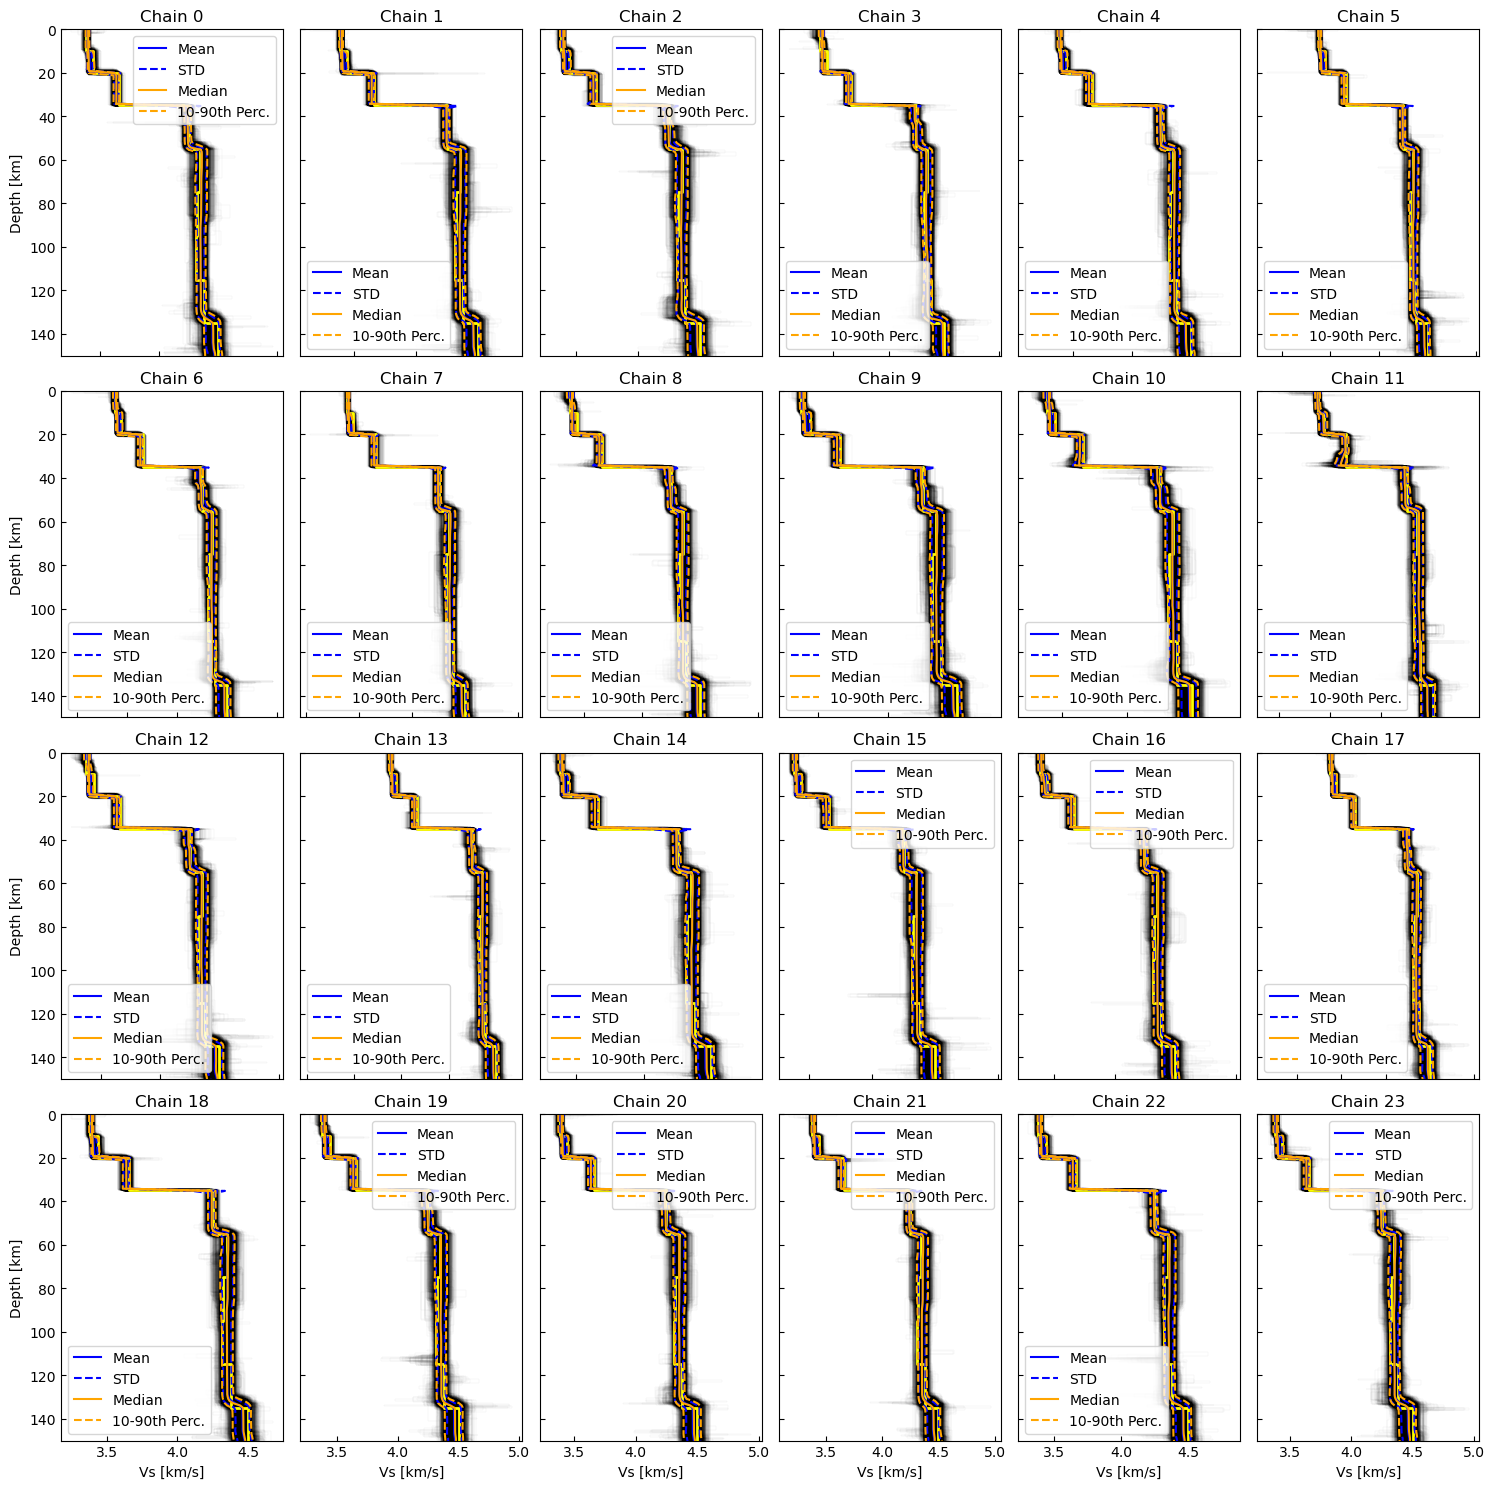

In [40]:
def get_subplot_layout(n_subplots):
    rows = int(np.sqrt(n_subplots))
    cols = int(np.ceil(n_subplots / rows))
    return rows, cols

rows, cols = get_subplot_layout(len(inversion.chains))
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
for ipanel, (ax, chain) in enumerate(zip(np.ravel(axes), inversion.chains)):
    saved_states = chain.saved_states
    saved_nuclei = saved_states["voronoi.discretization"]
    saved_vs = saved_states['voronoi.vs']
    
    Voronoi1D.plot_tessellations(saved_nuclei,
                                 saved_vs, 
                                 ax=ax, 
                                 linewidth=0.1, 
                                 color="k", 
                                 bounds=(0, 150))
    Voronoi1D.plot_tessellation(THICKNESS, 
                                VS, 
                                color='yellow', 
                                lw=2, 
                                ax=ax,
                                input_type='extents')
    Voronoi1D.plot_tessellation_statistics(
        saved_nuclei, saved_vs, interp_depths, ax=ax
    )
    
    ax.set_title(f'Chain {chain.id}')
    ax.tick_params(direction='in', labelleft=False, labelbottom=False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    if not ipanel % cols:
        ax.set_ylabel('Depth [km]')
        ax.tick_params(labelleft=True)
    if ipanel >= (rows-1) * cols:
        ax.set_xlabel('Vs [km/s]')
        ax.tick_params(labelbottom=True)
    
plt.tight_layout()
plt.show()